Training VAE (30 epochs)...
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 169ms/step - kl_loss: 9.3158 - loss: 365.9532 - reconstruction_loss: 356.6373
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 172ms/step - kl_loss: 14.1710 - loss: 268.7941 - reconstruction_loss: 254.6232
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 166ms/step - kl_loss: 12.0970 - loss: 258.7980 - reconstruction_loss: 246.7011
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 166ms/step - kl_loss: 10.8795 - loss: 254.2787 - reconstruction_loss: 243.3993
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 166ms/step - kl_loss: 10.2255 - loss: 251.6503 - reconstruction_loss: 241.4249
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 166ms/step - kl_loss: 9.9622 - loss: 249.6980 - reconstruction_loss: 239.7358
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 168ms/step - kl_loss: 9.8514 - loss: 248.7012 - reconstruction_loss: 238.8497
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 166ms/step - kl_loss: 9.8480 - loss: 248.3524 - reconstruction_loss: 2

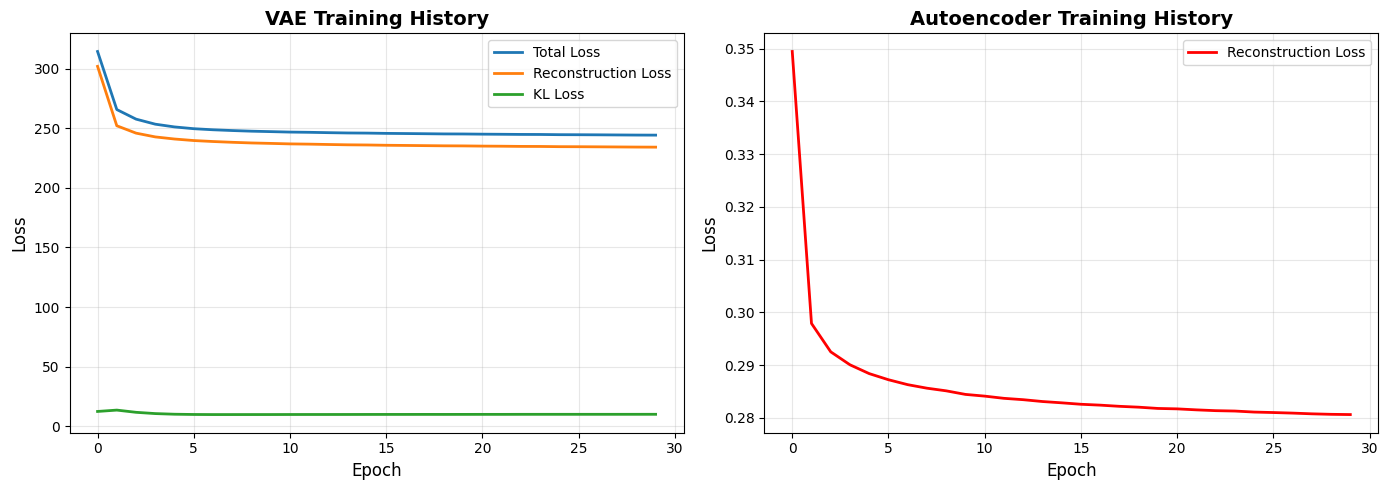

Creating latent space visualization with t-SNE...
Running t-SNE for VAE latent space...
Running t-SNE for Autoencoder latent space...


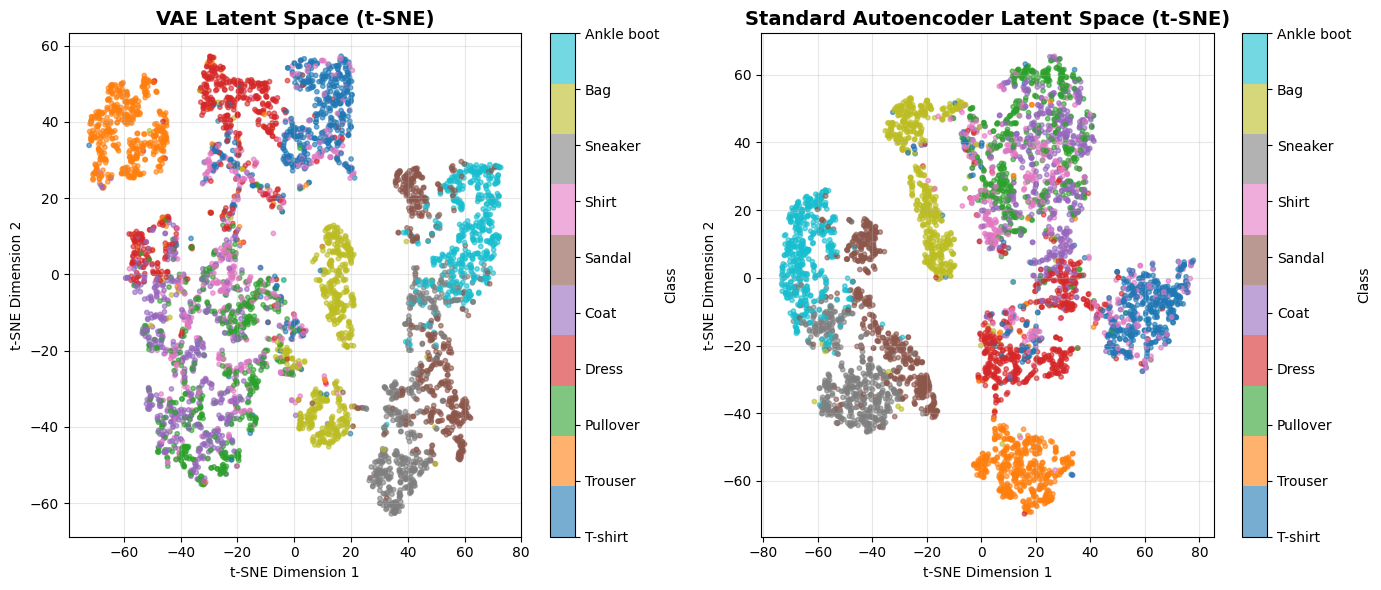

Performing latent space arithmetic...


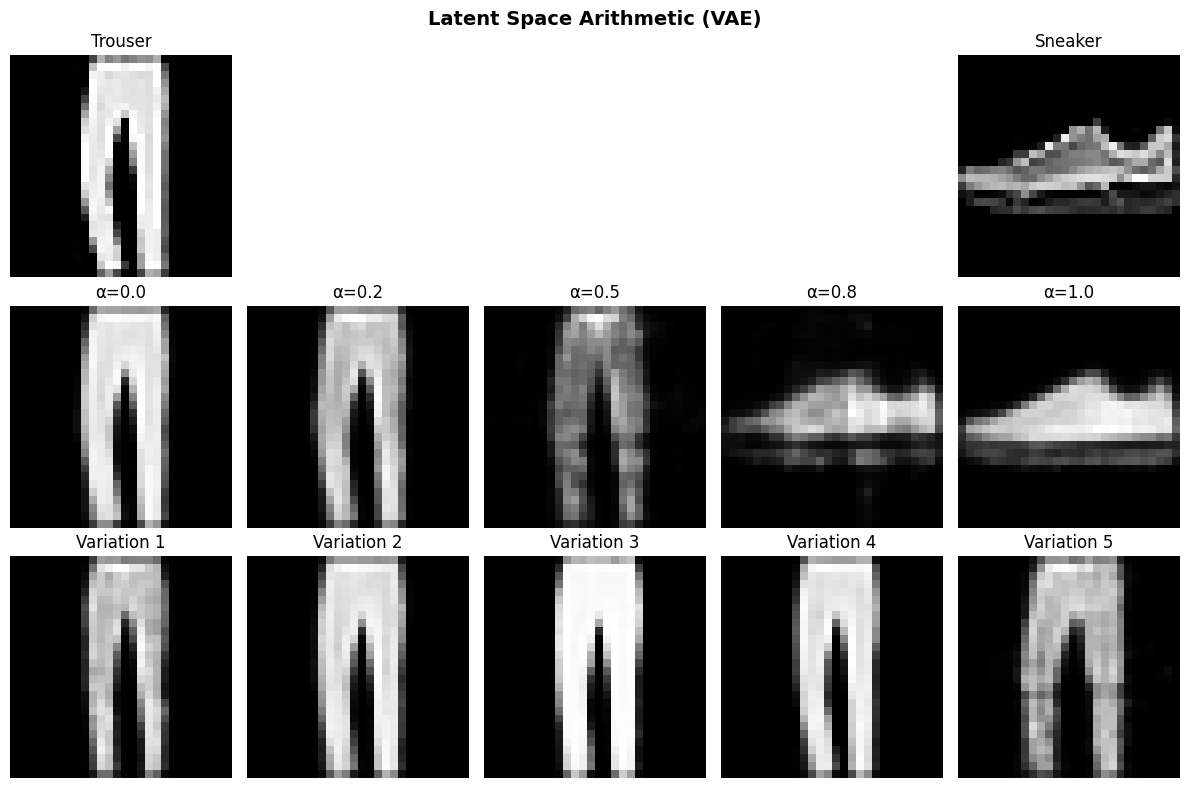

Comparing reconstructions...


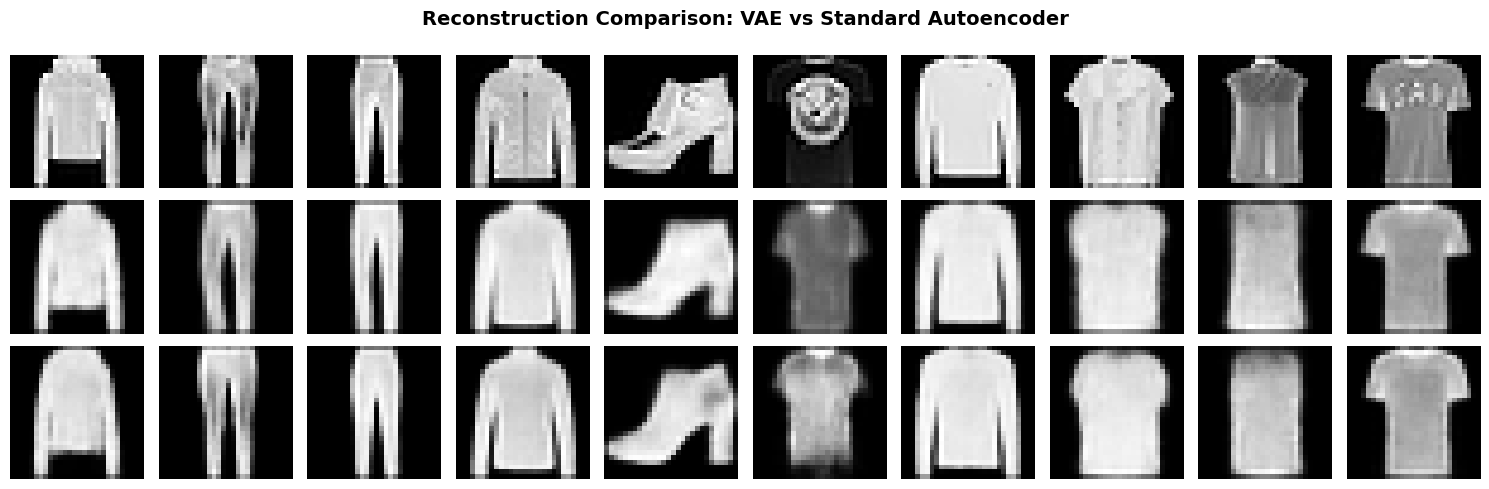

Generating new samples from VAE...


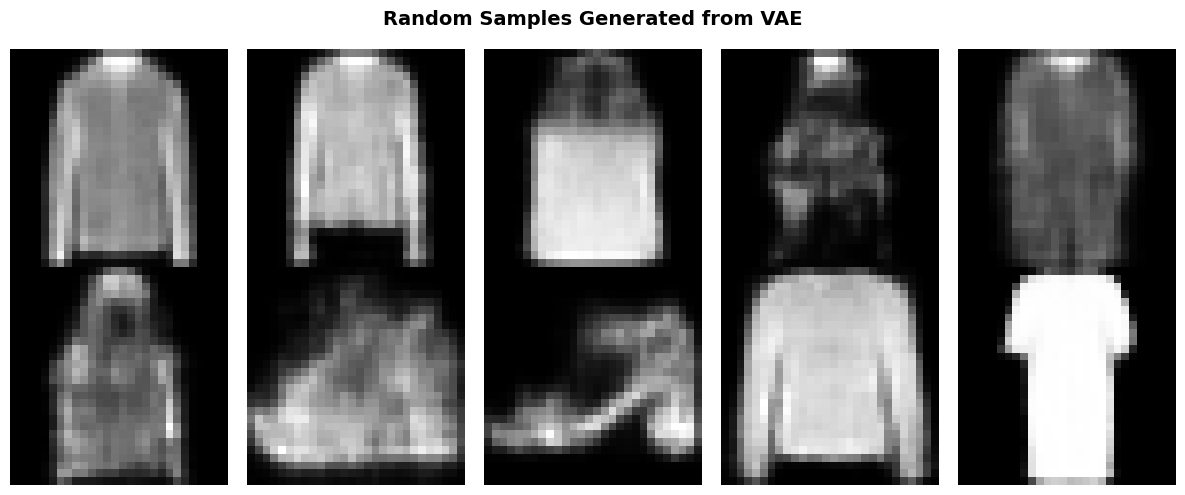

Analyzing reconstruction errors...


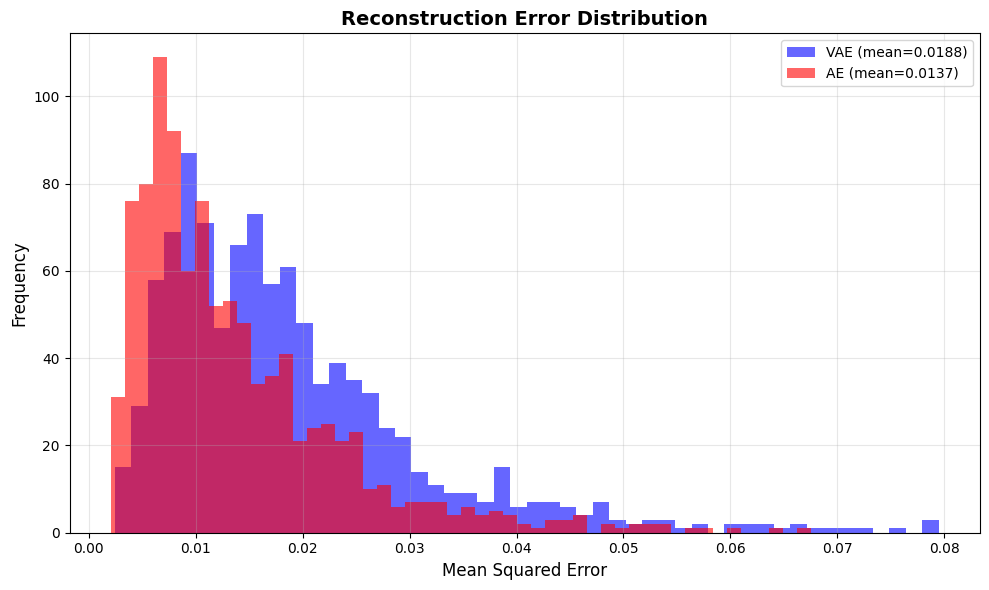


SUMMARY
VAE Mean Reconstruction Error: 0.018849
AE Mean Reconstruction Error:  0.013697

VAE advantages:
- Generates smooth, continuous latent space
- Can generate new samples from random latent vectors
- Better for interpolation between samples

Autoencoder advantages:
- Lower reconstruction error
- Simpler architecture and training
- Deterministic encoding


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.manifold import TSNE

# Load Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize and reshape
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Fashion-MNIST class names
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# VAE Components
latent_dim = 30

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build VAE Encoder
def build_vae_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

# Build VAE Decoder
def build_vae_decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

# VAE Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Build Standard Autoencoder
def build_autoencoder(latent_dim):
    # Encoder
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    latent = layers.Dense(latent_dim, activation="relu", name="latent")(x)
    encoder = keras.Model(encoder_inputs, latent, name="ae_encoder")

    # Decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="ae_decoder")

    # Full model
    autoencoder = keras.Model(encoder_inputs, decoder(encoder(encoder_inputs)), name="autoencoder")
    return encoder, decoder, autoencoder

# Train VAE
print("Training VAE (30 epochs)...")
vae_encoder = build_vae_encoder(latent_dim)
vae_decoder = build_vae_decoder(latent_dim)
vae = VAE(vae_encoder, vae_decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
vae_history = vae.fit(x_train, epochs=30, batch_size=128, verbose=1)

# Train Standard Autoencoder
print("\nTraining Standard Autoencoder (30 epochs)...")
ae_encoder, ae_decoder, autoencoder = build_autoencoder(latent_dim)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                   loss='binary_crossentropy')
ae_history = autoencoder.fit(x_train, x_train, epochs=30, batch_size=128, verbose=1)

print("\nTraining completed!\n")

# Plot Training History
print("Creating training history plots...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# VAE losses
axes[0].plot(vae_history.history['loss'], label='Total Loss', linewidth=2)
axes[0].plot(vae_history.history['reconstruction_loss'], label='Reconstruction Loss', linewidth=2)
axes[0].plot(vae_history.history['kl_loss'], label='KL Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('VAE Training History', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Autoencoder loss
axes[1].plot(ae_history.history['loss'], label='Reconstruction Loss', linewidth=2, color='red')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Autoencoder Training History', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# 1. Visualize Latent Space Distribution using t-SNE
print("Creating latent space visualization with t-SNE...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# VAE Latent Space (reduce to 2D using t-SNE)
z_mean_vae, _, _ = vae_encoder.predict(x_test[:5000], verbose=0)
print("Running t-SNE for VAE latent space...")
tsne_vae = TSNE(n_components=2, random_state=42, perplexity=30)
z_vae_2d = tsne_vae.fit_transform(z_mean_vae)
scatter1 = axes[0].scatter(z_vae_2d[:, 0], z_vae_2d[:, 1], c=y_test[:5000],
                          cmap='tab10', alpha=0.6, s=10)
axes[0].set_title('VAE Latent Space (t-SNE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0], ticks=range(10))
cbar1.set_label('Class')
cbar1.set_ticklabels([class_names[i] for i in range(10)])

# Autoencoder Latent Space (reduce to 2D using t-SNE)
z_ae = ae_encoder.predict(x_test[:5000], verbose=0)
print("Running t-SNE for Autoencoder latent space...")
tsne_ae = TSNE(n_components=2, random_state=42, perplexity=30)
z_ae_2d = tsne_ae.fit_transform(z_ae)
scatter2 = axes[1].scatter(z_ae_2d[:, 0], z_ae_2d[:, 1], c=y_test[:5000],
                          cmap='tab10', alpha=0.6, s=10)
axes[1].set_title('Standard Autoencoder Latent Space (t-SNE)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1], ticks=range(10))
cbar2.set_label('Class')
cbar2.set_ticklabels([class_names[i] for i in range(10)])

plt.tight_layout()
plt.savefig('latent_space_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 2. Latent Space Arithmetic (VAE)
print("Performing latent space arithmetic...")
fig, axes = plt.subplots(3, 5, figsize=(12, 8))

# Find examples of specific classes
trouser_idx = np.where(y_test == 1)[0][0]
sneaker_idx = np.where(y_test == 7)[0][0]

z_trouser, _, _ = vae_encoder.predict(x_test[trouser_idx:trouser_idx+1], verbose=0)
z_sneaker, _, _ = vae_encoder.predict(x_test[sneaker_idx:sneaker_idx+1], verbose=0)

# Show original images
axes[0, 0].imshow(x_test[trouser_idx].reshape(28, 28), cmap='gray')
axes[0, 0].set_title('Trouser')
axes[0, 0].axis('off')

axes[0, 4].imshow(x_test[sneaker_idx].reshape(28, 28), cmap='gray')
axes[0, 4].set_title('Sneaker')
axes[0, 4].axis('off')

# Interpolation
for i, alpha in enumerate(np.linspace(0, 1, 5)):
    z_interpolated = (1 - alpha) * z_trouser + alpha * z_sneaker
    img = vae_decoder.predict(z_interpolated, verbose=0)

    axes[1, i].imshow(img[0].reshape(28, 28), cmap='gray')
    axes[1, i].set_title(f'α={alpha:.1f}')
    axes[1, i].axis('off')

# Random variations around trouser
for i in range(5):
    z_varied = z_trouser + np.random.normal(0, 0.5, z_trouser.shape)
    img = vae_decoder.predict(z_varied, verbose=0)

    axes[2, i].imshow(img[0].reshape(28, 28), cmap='gray')
    axes[2, i].set_title(f'Variation {i+1}')
    axes[2, i].axis('off')

axes[0, 1].axis('off')
axes[0, 2].axis('off')
axes[0, 3].axis('off')

plt.suptitle('Latent Space Arithmetic (VAE)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('latent_arithmetic.png', dpi=150, bbox_inches='tight')
plt.show()

# 3. Reconstruction Comparison
print("Comparing reconstructions...")
n_samples = 10
test_indices = np.random.choice(len(x_test), n_samples)

fig, axes = plt.subplots(3, n_samples, figsize=(15, 5))

for i, idx in enumerate(test_indices):
    # Original
    axes[0, i].imshow(x_test[idx].reshape(28, 28), cmap='gray')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=10, fontweight='bold')
    axes[0, i].axis('off')

    # VAE Reconstruction
    z_mean, _, _ = vae_encoder.predict(x_test[idx:idx+1], verbose=0)
    vae_recon = vae_decoder.predict(z_mean, verbose=0)
    axes[1, i].imshow(vae_recon[0].reshape(28, 28), cmap='gray')
    if i == 0:
        axes[1, i].set_ylabel('VAE', fontsize=10, fontweight='bold')
    axes[1, i].axis('off')

    # Autoencoder Reconstruction
    ae_recon = autoencoder.predict(x_test[idx:idx+1], verbose=0)
    axes[2, i].imshow(ae_recon[0].reshape(28, 28), cmap='gray')
    if i == 0:
        axes[2, i].set_ylabel('Autoencoder', fontsize=10, fontweight='bold')
    axes[2, i].axis('off')

plt.suptitle('Reconstruction Comparison: VAE vs Standard Autoencoder',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('reconstruction_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 4. Generation from Random Latent Vectors (VAE)
print("Generating new samples from VAE...")
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(10):
    z_sample = np.random.normal(0, 1, (1, latent_dim))
    generated = vae_decoder.predict(z_sample, verbose=0)

    row = i // 5
    col = i % 5
    axes[row, col].imshow(generated[0].reshape(28, 28), cmap='gray')
    axes[row, col].axis('off')

plt.suptitle('Random Samples Generated from VAE', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('vae_generated_samples.png', dpi=150, bbox_inches='tight')
plt.show()

# 5. Reconstruction Error Analysis
print("Analyzing reconstruction errors...")
n_test = 1000
vae_errors = []
ae_errors = []

for i in range(n_test):
    original = x_test[i:i+1]

    # VAE error
    z_mean, _, _ = vae_encoder.predict(original, verbose=0)
    vae_recon = vae_decoder.predict(z_mean, verbose=0)
    vae_errors.append(np.mean((original - vae_recon) ** 2))

    # AE error
    ae_recon = autoencoder.predict(original, verbose=0)
    ae_errors.append(np.mean((original - ae_recon) ** 2))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(vae_errors, bins=50, alpha=0.6, label=f'VAE (mean={np.mean(vae_errors):.4f})', color='blue')
ax.hist(ae_errors, bins=50, alpha=0.6, label=f'AE (mean={np.mean(ae_errors):.4f})', color='red')
ax.set_xlabel('Mean Squared Error', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Reconstruction Error Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('reconstruction_error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"VAE Mean Reconstruction Error: {np.mean(vae_errors):.6f}")
print(f"AE Mean Reconstruction Error:  {np.mean(ae_errors):.6f}")
print(f"\nVAE advantages:")
print("- Generates smooth, continuous latent space")
print("- Can generate new samples from random latent vectors")
print("- Better for interpolation between samples")
print(f"\nAutoencoder advantages:")
print("- Lower reconstruction error")
print("- Simpler architecture and training")
print("- Deterministic encoding")
print("="*60)